<a href="https://colab.research.google.com/github/PatriciaBonert/data-scientist/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/900.jpg" width="60%"></p>

Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/54.jpg" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [0]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

#configurar o estilo dos gráficos com seaborn
sns.set_style('dark')

In [0]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.17% do dataset.



[]

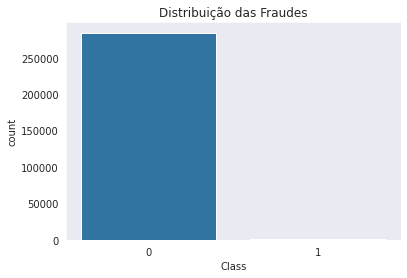

In [3]:
#verificar se há valores ausentes
df.isnull().sum().max

#ver o balanceamento dos dados de fraudes
print(df.Class.value_counts())
print("\nFraudes representam {:.2f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0])*100))

#plotar gráfico de barras
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Fraudes')
plt.plot()


Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Preparação dos Dados

* Normalizar os dados que ainda não haviam sido pré-processados (`Time` e `Amount`)
* Dividir o conjunto de dados entre treino e teste
* Balancear o conjunto de dados

Como os dados estão desbalanceados, algumas estratérgias devem ser consideradas:

**Mudar a métrica de performance:**

* Usar a matriz de confusão para calcular a Precisão (Recall)
* F1score - média ponderada da Precisão-Recall
* Usar Kappa - classificação de acurácia normalizada pelo desbalanceamento dos dados
* Curvas ROC - calcula a razão da sensibilidade/especificidade

**Reamostrar o dataset**

* Método que processa os dados numa razão 50/50
* Realizar Over-sampling(poucos dados) ou Under-sampling(muitos dados)

In [4]:
from sklearn.preprocessing import StandardScaler

#padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))

df_clean.drop(['Time', 'Amount'],axis=1, inplace=True)

#ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [0]:
from sklearn.model_selection import train_test_split

#separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

#dividir dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

1    369
0    369
dtype: int64


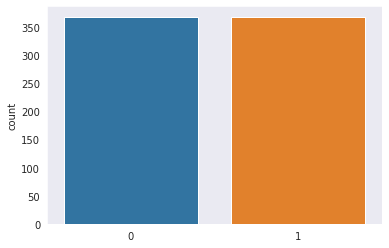

In [6]:
from imblearn.under_sampling import RandomUnderSampler

#usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

#ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

#plotar a nova distribuição de classes
sns.countplot(y_rus)

## Modelo de Machine Learning

* Regressão logística

Enquanto na Regressão Linear temos uma variável resposta contínua, na Regressão Logística nossa variável resposta é binária, 0 ou 1, sim ou não. Essa análise é, normalmente, utilizada quando se quer medir a relação de uma variável dependente binária com uma ou mais variáveis independentes, sendo que as independentes tanto podem ser categóricas ou não.

A Regressão Logística é uma análise que nos permite estimar a probabilidade associada à ocorrência de determinado evento em face de um conjunto de variáveis explanatórias. As vantagens desse tipo de regressão incluem: (a) facilidade para lidar com variáveis independentes categóricas; (b) fornece resultados em termos de probabilidade; (c) facilidade de classificação de indivíduos em categorias; (d) requer pequeno número de suposições; e (e) possui alto grau de confiabilidade.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, accuracy_score 

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9492    0.9739     71079
           1     0.0319    0.9675    0.0617       123

    accuracy                         0.9492     71202
   macro avg     0.5159    0.9583    0.5178     71202
weighted avg     0.9983    0.9492    0.9723     71202

Acurácia: 0.95

AUC: 0.96



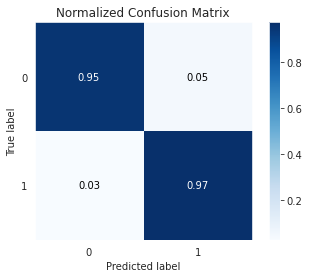

In [8]:
#instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

#fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

#imprimir relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

#imprimr a acurácia do modelo
print('Acurácia: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

#imprimir a área sob a curva
print('AUC: {:.2f}\n'.format(roc_auc_score(y_test, y_pred)))

#plotar matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True);

* Modelo de classificação Random Forest

O algoritmo de floresta aleatória adiciona aleatoriedade extra ao modelo, quando está criando as árvores. Ao invés de procurar pela melhor característica ao fazer a partição de nós, ele busca a melhor característica em um subconjunto aleatório das características. Este processo cria uma grande diversidade, o que geralmente leva a geração de modelos melhores.

O índice Gini diz que se selecionarmos aleatoriamente dois itens de uma população, então ambos devem ser da mesma classe e a probabilidade disto é 1 se a população for pura.

  1. Funciona com a variável alvo categórica“Sucesso” ou “Falha”
  2. Executa apenas divisões binárias
  3. Quanto maior o valor de Gini, maior a homogeneidade
  4. O CART (Árvore de Classificação e Regressão) usa o método Gini para criar divisões binárias

Passos para calcular o Gini de uma divisão:

  1. Cálculo do Gini para sub-nós, calcule a soma dos quadrados da probabilidade de sucesso e e da de fracasso (p ^ 2 + q ^ 2)
  2. Calcule o Gini para a divisão, use a pontuação de Gini ponderada de cada nó dessa divisão



In [9]:
from sklearn.ensemble import RandomForestClassifier

target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']
RANDOM_STATE = 2018
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#inicializando a classificação
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

#treino do dataset
clf.fit(X_rus, y_rus)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

In [0]:
preds = clf.predict(X_test)


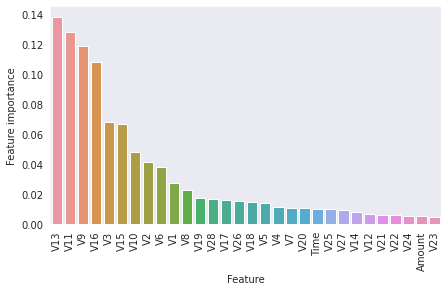

In [18]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)
plt.figure(figsize = (7,4))
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

In [20]:
#área sob a curva
roc_auc_score(y_test.values, preds)


0.9577704505361434

###Conclusão analítica

A partir da análise exploratória de dados após seu tratamento adequado, foram desenvolvidos dois modelos de predição: Regressão Logística e Random Forest.

O AUC representa o grau ou medida de separabilidade. Quanto maior o AUC, melhor o modelo está em prever 0s como 0s e 1s como 1s.

Um modelo excelente tem AUC próximo ao 1, o que significa que tem boa medida de separabilidade. Um modelo pobre tem AUC próximo do 0, o que significa que tem a pior medida de separabilidade, ou seja, está prevendo 0s como 1s e 1s como 0s. E quando a AUC é 0,5, significa que o modelo não tem capacidade de separação de classe.

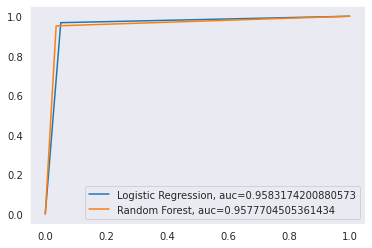

In [22]:
from sklearn import metrics 

#AUC Curves
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)
plt.show()